In [75]:
import pystac_client
import planetary_computer
import rasterio
import rioxarray as rxr
import xarray as xr
import warnings
import numpy as np
from odc.stac import stac_load
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore", category=UserWarning)

In [76]:
# Geographic bounds for NYC (Bronx/Manhattan area)
lower_left  = (40.75, -74.01)  # (lat, lon)
upper_right = (40.88, -73.86)  # (lat, lon)
bounds = (lower_left[1], lower_left[0], upper_right[1], upper_right[0])  # (min_lon, min_lat, max_lon, max_lat)

# Cloud masks (you can RELAX these if you're losing all data):
LANDSAT_VALID_QA = [322, 386]   # maybe you want to include more codes?
S2_VALID_SCL = [2, 4, 5, 6]     # you might want to also keep 7=clouds low prob?

In [77]:
def produce_landsat_tiff_v5(
    date_window, approach="single", out_filename="Landsat_LST_v5.tiff",
    relax_mask=False
):
    """
    Produce a Landsat LST GeoTIFF either using a single best scene (lowest cloud cover)
    or a median mosaic over the given date window. Checks for valid data; logs ratio.
    
    :param date_window: "YYYY-MM-DD/YYYY-MM-DD"
    :param approach: "single" or "median"
    :param out_filename: Name of the output TIF
    :param relax_mask: If True, skip or reduce QA masking, so you don't end up with an empty TIF.
    """
    print(f"\n=== produce_landsat_tiff_v5 ===")
    print(f"Date window: {date_window}, Approach: {approach}, Output: {out_filename}")
    
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bounds,
        datetime=date_window,
        collections=["landsat-c2-l2"],
        query={"platform": {"in": ["landsat-8"]}}
    )
    items = list(search.get_items())
    print(f"  Found Landsat items in range: {len(items)}")
    if not items:
        print("No items => skipping.")
        return

    signed_items = [planetary_computer.sign(item) for item in items]
    # We'll load lwir11 (thermal) + qa_pixel
    # If you want to skip QA, omit 'qa_pixel' or do a partial mask:
    bands_of_interest = ["lwir11"]
    if not relax_mask:
        bands_of_interest.append("qa_pixel")

    # ~30m => deg scale
    resolution = 30 / 111320.0

    ds = stac_load(
        signed_items,
        bands=bands_of_interest,
        crs="EPSG:4326",
        resolution=resolution,
        chunks={"x": 2048, "y": 2048},
        bbox=bounds)
    # ).persist()

    if "lwir11" not in ds.data_vars:
        print("No lwir11 band => skipping.")
        return

    # Convert thermal DN => Celsius
    scale = 0.00341802
    offset = 149.0
    ds["lwir11"] = ds["lwir11"] * scale + offset - 273.15

    # If we want to do QA mask:
    if not relax_mask and "qa_pixel" in ds.data_vars:
        mask = ds["qa_pixel"].isin(LANDSAT_VALID_QA)
        ds = ds.where(mask)
    else:
        print("Skipping QA mask or no qa_pixel present...")

    # single vs. median
    if approach=="single":
        items_sorted = sorted(items, key=lambda i: i.properties["eo:cloud_cover"])
        best_item = items_sorted[0]
        best_item_id = best_item.id
        print(f"  => Single scene: {best_item_id}, cloud={best_item.properties['eo:cloud_cover']}")
        item_ids = [itm.id for itm in signed_items]
        idx = item_ids.index(best_item_id)
        if "time" in ds.dims:
            ds = ds.isel(time=idx)
    elif approach=="median":
        print("  => median mosaic over all items.")
        if "time" in ds.dims:
            ds = ds.median(dim="time", skipna=True)
    else:
        print(f"Unknown approach: {approach}")
        return

    # If "time" remains with size=1
    if "time" in ds.dims and ds.sizes["time"]==1:
        ds = ds.isel(time=0)

    # We only need the lwir11 band
    if "lwir11" not in ds:
        print("No lwir11 after selection => skipping.")
        return
    final_data = ds["lwir11"]

    # Check how many are NaN
    valid_ratio = (~final_data.isnull()).mean().values
    print(f"Landsat final valid ratio: {valid_ratio:.3f}")
    if valid_ratio==0.0:
        print("WARNING => This TIF is 100% NaN. Possibly no valid pixels in bounding box+date+QA.")
        print("Consider relax_mask=True or picking a different date/scene.")

    # Save as EPSG:4326
    final_data.rio.write_crs("EPSG:4326", inplace=True)
    final_data.rio.to_raster(out_filename, compress="lzw")
    print(f"Saved => {out_filename}")

def produce_s2_tiff_v5(
    date_window, 
    approach="single", 
    out_filename="S2_indices_v5.tiff",
    relax_mask=False
):
    """
    Produce NDVI, NDBI, NDWI, EVI, MNDWI from S2-L2A. 
    If all masked => 0% valid => TIF is empty.
    Will produce a 5-band GeoTIFF:
       band=1 => NDVI
       band=2 => NDBI
       band=3 => NDWI
       band=4 => EVI
       band=5 => MNDWI
    """
    print(f"\n=== produce_s2_tiff_v5 ===")
    print(f"Date window: {date_window}, Approach: {approach}, Output: {out_filename}")

    # 1. STAC search
    stac = pystac_client.Client.open("https://planetarycomputer.microsoft.com/api/stac/v1")
    search = stac.search(
        bbox=bounds,
        datetime=date_window,
        collections=["sentinel-2-l2a"],
        query={"eo:cloud_cover": {"lt": 90}}
    )
    items = list(search.get_items())
    print(f"  Found S2 items: {len(items)}")
    if not items:
        print("No items => skipping.")
        return

    # 2. Sign items
    signed_items = [planetary_computer.sign(it) for it in items]

    # 3. We want B02(blue), B03(green), B04(red), B08(NIR), B11(SWIR), SCL for optional mask
    band_list = ["B02","B03","B04","B08","B11"]
    if not relax_mask:
        band_list.append("SCL")

    resolution = 10/111320.0

    ds = stac_load(
        signed_items,
        bands=band_list,
        crs="EPSG:4326",
        resolution=resolution,
        chunks={"x":2048, "y":2048},
        bbox=bounds)

    # 4. If we want an SCL-based mask:
    if not relax_mask and "SCL" in ds.data_vars:
        scl_mask = ds["SCL"].isin(S2_VALID_SCL)
        ds = ds.where(scl_mask)
    else:
        print("Skipping SCL mask or no SCL present...")

    # 5. Single vs. median mosaic
    if approach=="single":
        # pick best item by cloud cover
        items_sorted = sorted(items, key=lambda i: i.properties["eo:cloud_cover"])
        best_item = items_sorted[0]
        best_item_id = best_item.id
        print(f"  => single => {best_item_id}, cloud={best_item.properties['eo:cloud_cover']}")
        item_ids = [it.id for it in signed_items]
        idx = item_ids.index(best_item_id)
        if "time" in ds.dims:
            ds=ds.isel(time=idx)
    elif approach=="median":
        print(" => median mosaic")
        if "time" in ds.dims:
            ds = ds.median(dim="time", skipna=True)
    else:
        print(f"Unknown approach: {approach}")
        return

    if "time" in ds.dims and ds.sizes["time"]==1:
        ds = ds.isel(time=0)

    # 6. Check required bands
    for b in ["B02","B03","B04","B08","B11"]:
        if b not in ds.data_vars:
            print(f"Missing {b} => skipping generation.")
            return

    # rename for clarity
    blue = ds["B02"]
    green= ds["B03"]
    red  = ds["B04"]
    nir  = ds["B08"]
    swir = ds["B11"]

    # 7. Compute indices
    ndvi  = (nir - red) / (nir + red)
    ndbi  = (swir - nir) / (swir + nir)
    ndwi  = (green - nir) / (green + nir)
    evi   = 2.5*(nir - red)/(nir + 6*red - 7.5*blue + 1.0)
    mndwi = (green - swir)/(green + swir)

    # 8. Concatenate => band dimension
    # e.g. band=1 => NDVI, band=2 => NDBI, band=3 => NDWI, band=4 => EVI, band=5 => MNDWI
    indices = xr.concat([ndvi, ndbi, ndwi, evi, mndwi], dim="band")
    indices["band"] = [1,2,3,4,5]

    # 9. Check valid ratio
    valid_ratio = (~indices.isnull()).mean().values
    print(f"S2 final valid ratio: {valid_ratio:.3f}")
    if valid_ratio==0.0:
        print("WARNING => 100% NaN => skipping.")
        return

    # 10. Save
    indices.rio.write_crs("EPSG:4326", inplace=True)
    indices.rio.to_raster(out_filename, compress="lzw")
    print(f"Saved => {out_filename}")

In [78]:
date_window="2021-06-01/2021-09-01"

if __name__=="__main__":
    # Examples of usage
    # If you're getting blank TIF => try relax_mask=True
    produce_landsat_tiff_v5(
        date_window=date_window,
        approach="single",
        out_filename="Landsat_LST_v5_single.tiff",
        relax_mask=True  # set True to skip QA pixel removal
    )

    produce_landsat_tiff_v5(
        date_window=date_window,
        approach="median",
        out_filename="Landsat_LST_v5_median.tiff",
        relax_mask=True
    )

    produce_s2_tiff_v5(
        date_window=date_window,
        approach="single",
        out_filename="S2_indices_v5_single.tiff",
        relax_mask=True
    )

    produce_s2_tiff_v5(
        date_window=date_window,
        approach="median",
        out_filename="S2_indices_v5_median.tiff",
        relax_mask=False
    )

    print("Done")


=== produce_landsat_tiff_v5 ===
Date window: 2021-06-01/2021-09-01, Approach: single, Output: Landsat_LST_v5_single.tiff
  Found Landsat items in range: 17
Skipping QA mask or no qa_pixel present...
  => Single scene: LC08_L2SP_014031_20210607_02_T1, cloud=6.88
Landsat final valid ratio: 1.000
Saved => Landsat_LST_v5_single.tiff

=== produce_landsat_tiff_v5 ===
Date window: 2021-06-01/2021-09-01, Approach: median, Output: Landsat_LST_v5_median.tiff
  Found Landsat items in range: 17
Skipping QA mask or no qa_pixel present...
  => median mosaic over all items.
Landsat final valid ratio: 1.000
Saved => Landsat_LST_v5_median.tiff

=== produce_s2_tiff_v5 ===
Date window: 2021-06-01/2021-09-01, Approach: single, Output: S2_indices_v5_single.tiff
  Found S2 items: 28
Skipping SCL mask or no SCL present...
  => single => S2B_MSIL2A_20210606T153809_R011_T18TWL_20210609T213133, cloud=1.243344
S2 final valid ratio: 1.000
Saved => S2_indices_v5_single.tiff

=== produce_s2_tiff_v5 ===
Date window

In [82]:
lst_tiff_path = "Landsat_LST_v5_median.tiff"
indices_tiff_path = "S2_indices_v5_median.tiff"

NDVI Tiff Bounds: BoundingBox(left=-74.0101509162774, bottom=40.749820337765, right=-73.85977362558391, top=40.8802551203737)
CRS: EPSG:4326
Width, Height: 558 484
Number of bands: 1


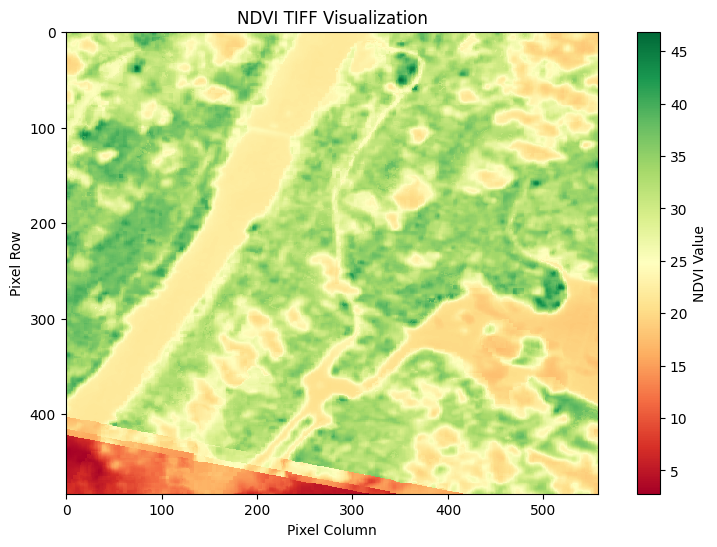

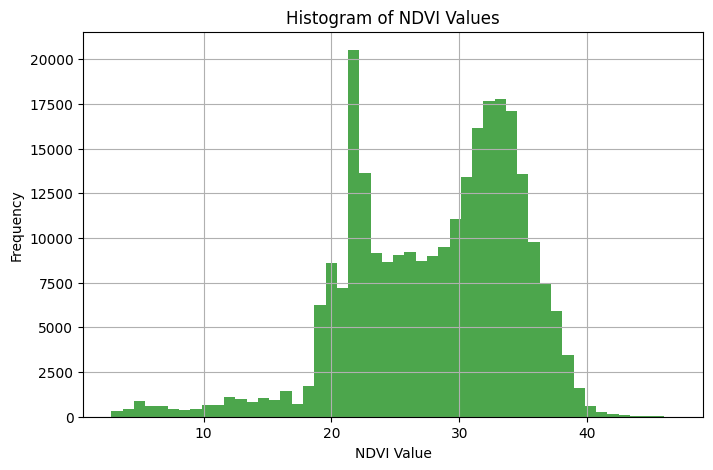

In [83]:
with rasterio.open(lst_tiff_path) as src:
    # Print metadata
    print("NDVI Tiff Bounds:", src.bounds)
    print("CRS:", src.crs)
    print("Width, Height:", src.width, src.height)
    print("Number of bands:", src.count)

    # Read the first band (assuming it's a single-band raster or NDVI index)
    band1 = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 6))
    plt.imshow(band1, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(label="NDVI Value")
    plt.title("NDVI TIFF Visualization")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    # Plot a histogram of NDVI values
    plt.figure(figsize=(8, 5))
    plt.hist(band1.flatten(), bins=50, color='green', alpha=0.7)
    plt.title("Histogram of NDVI Values")
    plt.xlabel("NDVI Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()

NDVI Tiff Bounds: BoundingBox(left=-74.0100610851599, bottom=40.75, right=-73.85995328781891, top=40.8800754581387)
CRS: EPSG:4326
Width, Height: 1671 1448
Number of bands: 5


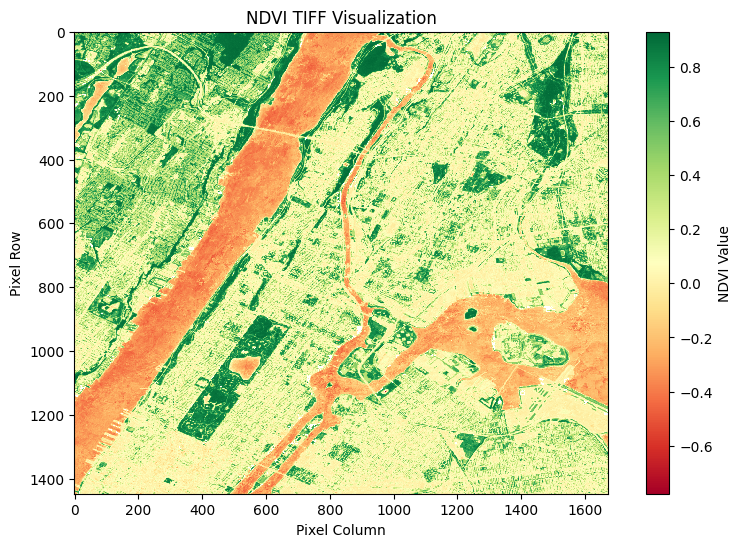

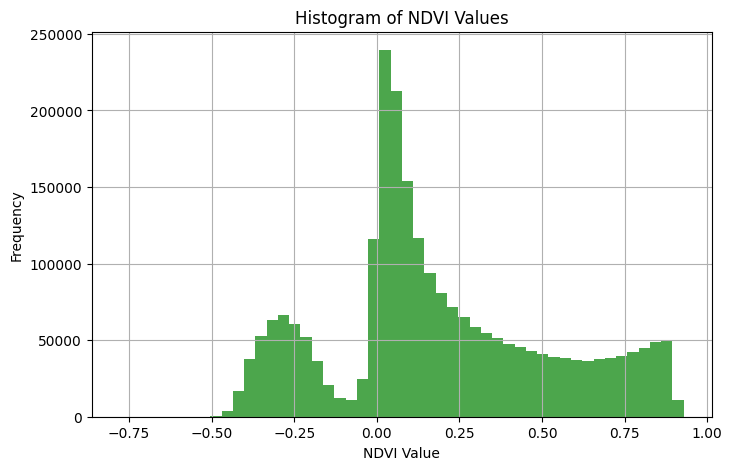

In [84]:
with rasterio.open(indices_tiff_path) as src:
    # Print metadata
    print("NDVI Tiff Bounds:", src.bounds)
    print("CRS:", src.crs)
    print("Width, Height:", src.width, src.height)
    print("Number of bands:", src.count)

    # Read the first band (assuming it's a single-band raster or NDVI index)
    band1 = src.read(1)
    
    # Plot the raster data
    plt.figure(figsize=(10, 6))
    plt.imshow(band1, cmap='RdYlGn', interpolation='nearest')
    plt.colorbar(label="NDVI Value")
    plt.title("NDVI TIFF Visualization")
    plt.xlabel("Pixel Column")
    plt.ylabel("Pixel Row")
    plt.show()
    
    # Plot a histogram of NDVI values
    plt.figure(figsize=(8, 5))
    plt.hist(band1.flatten(), bins=50, color='green', alpha=0.7)
    plt.title("Histogram of NDVI Values")
    plt.xlabel("NDVI Value")
    plt.ylabel("Frequency")
    plt.grid()
    plt.show()